# ECMs

This module contains different types of episodic and compositional memories (ECMs)

In [ ]:
#| default_exp ECMs

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# ECMs constructors

Here we collect different standalone functions that will help us construct different types of ECM

## ECM updaters

In [ ]:
#| export
def standard_ps_upd(reward, hmatrix, gmatrix, h_damp, g_damp):
    """
    Given a reward, updates h-matrix and g-matrix following the standard PS update rule:

    h <- h - h_damp*(h-1)+ reward*g
    g <- (1-g_damp)*g    
    """
    # damping h-matrix
    hmatrix = hmatrix - h_damp*(hmatrix-1.)
    # update h-matrix
    hmatrix += reward*gmatrix
    # update g-matrix
    gmatrix = (1-g_damp)*gmatrix

    return hmatrix, gmatrix

# Pre-built ECMs

Here we collect the abstract parent class that any ECM should be built upon as well as some pre-built ECM ready to use.

#| hide

## Abstract ECM

In [ ]:
#| export
from projective_simulation.methods.lib_helpers import CustomABCMeta
from abc import abstractmethod


class Abstract_ECM(metaclass = CustomABCMeta):
    """
    Abstract agent class any episodic and compositional memory (ECM) should be derived from. Asserts that the necessary methods are implemented.
    """

    def __init__(self):
        '''
        No restrictions on the constructor, as the ECM can be anything that has a sample module.
        '''
        pass

    @abstractmethod
    def sample(self,):
        """
        Performs a random walk through the ECM. Typically, this implies receiving an input percept and returning an action.
        """
        pass

In [ ]:
#| hide

### Test ###

class test_abstract(Abstract_ECM):

    def __init__(self, num_actions = 2):
        self.num_actions = num_actions

        super().__init__()

    # Here we do not define on purpose the sample method, to check if the abstract class raises an error when trying to instantiate it.
    # def sample(self):
    #     return 0

try:
    agent = test_abstract()  # This should raise a TypeError
except TypeError:
    print("Got the expected TypeError, test passed.")
else:
    raise AssertionError("TestAgent() did NOT raise TypeError but it should have.") 


Got the expected TypeError, test passed.


## Two Layer ECMs

### Basic Two Layer

In [ ]:
#| export
import numpy as np
from projective_simulation.methods.transforms import _softmax

class Two_Layer(Abstract_ECM):
    def __init__(self, 
                 # The number of available actions.
                 num_actions: int, 
                 # The glow damping(or eta) parameter. 
                 g_damp: float, 
                 # The damping (or gamma) parameter. 
                 h_damp: float,
                 # If 'greedy', uses a greedy policy that samples the most action based on the h-matrix. 
                 # If 'softmax', uses a softmax policy that samples an action based on the h-matrix and a temperature parameter (encoded in policy_parameters).
                 # If object, uses this object to sample action. Input must be h_values corresponding to current percept + arbitrary policy_parameters.
                 policy: str = 'greedy',                 
                 # The parameters of the policy.
                 policy_parameters: dict = None,
                 # Method to update the g-matrix. 
                 # If 'sum', adds the new value to the current value.
                 # If 'init', sets the new value to 1.
                 glow_method: str = 'sum',
                ):

        """
        Two layer ECM. First layer, encoding the percepts observed in an environment, is initially empty (e.g. self.num_percepts = 0). As percepts
        are observed, they are added to the ECM and to the percept dictionary self.percepts. 
        The second layer, encoding the actions, has size self.num_actions.
        In practice, the ECM graph is never created. Instead, it is defined indirectly by the h-matrix and g-matrix. 
        Both have size (self.num_percepts, self.num_actions). 
        The input policy (greedy, softmax or other) is used to sample actions based on the h-matrix.

        For an end-to-end example of how to use this class, see the tutorial notebook on Basic PS agents.        
        """

        

        self.num_actions = num_actions

        self.h_damp = h_damp
        self.g_damp = g_damp
        self.glow_method = glow_method

        self.policy = policy
        self.policy_parameters = policy_parameters
        
        # Initialize ECM structures

        #int: current number of percepts.
        self.num_percepts = 0
        #np.ndarray: h-matrix with current h-values. Defaults to all 1.
        self.hmatrix = np.ones([0,self.num_actions])
        #np.ndarray: g-matrix with current glow values. Defaults to all 0.
        self.gmatrix = np.zeros([0,self.num_actions])
        #dict: Dictionary of percepts as {"percept": index}
        self.percepts = {}

    def sample(self, percept: str):
        """
        Given a percept, returns an action and changes the ECM if necessary
        First, if the percept is new, it will be added to the ECM
        Then, an action is selected as a function of the percept and the h-values of edges connected to that percept
        Finally, the g-matrix is updated based on the realized percept-action pair.
        """

        # Add percept to ECM if not already present
        self.add_percept(percept)
        # Get index from dictionary entry
        percept_index = self.percepts[percept]
        # Get h-values
        h_values = self.hmatrix[percept_index]

        # Perform Random Walk through the ECM based on h_values and current policy
        if self.policy == 'greedy': 
            # Sample greedly the action with the highest h-value
            h_values = self.hmatrix[percept_index]
            action = h_values.argmax()   

        elif self.policy == 'softmax':
            # Get probabilities from h-values through a softmax function
            prob = _softmax(self.policy_parameters, h_values)
            # Sample action based on probabilities
            action = np.random.choice(range(self.num_actions), p=prob) 

        else:
            # This considers a custom policy
            action = self.policy(h_values = h_values, **self.policy_parameters)

        # Update g-matrix
        if self.glow_method == 'sum':
            self.gmatrix[int(percept_index),int(action)] += 1.
        if self.glow_method == 'init':
            self.gmatrix[int(percept_index),int(action)] = 1.
            

        return action

    def add_percept(self, percept):
        '''
        Checks if percept is in dictionary and adds to ECM in not
        '''
        if percept not in self.percepts.keys(): 
            self.percepts[percept] = self.num_percepts
            # increment number of percepts
            self.num_percepts += 1
            # add column to h-matrix
            self.hmatrix = np.append(self.hmatrix, 
                                     np.ones([1,self.num_actions]),
                                     axis=0)
            # add column to g-matrix
            self.gmatrix = np.append(self.gmatrix, 
                                    np.zeros([1,self.num_actions]),
                                    axis=0)

    def  learn(self, reward):
        """
        Updates the h-matrix and g-matrix based on the reward received using the standard PS update rule.
        """
        self.hmatrix, self.gmatrix = standard_ps_upd(reward, self.hmatrix, self.gmatrix, self.h_damp, self.g_damp)

In [ ]:
#| hide

### Test ###

# Greedy policy
ECM_2l_greedy = Two_Layer(4,1,1)
ECM_2l_greedy.sample(0)

# Softmax policy
ECM_2l_softmax = Two_Layer(4,1,1, policy = 'softmax', policy_parameters = 1)
ECM_2l_softmax.sample(0);

### Priming Two Layer

In [ ]:
#| export
from projective_simulation.methods.transforms import _softmax

class Priming_ECM(Two_Layer):
    '''
    This sub-class of the Two-Layer ECM adds a variable for action priming.
    This variable should be a list of floats, each element of which corresponds to an action in the ECM.
    These "priming values" are summed with h-values of any edge connected to the associated action node prior to calculating walk probabilites with the softmax function
    '''
    def __init__(self, 
                 num_actions: int, # The number of available actions.                 
                 glow: float = 0.1, # The glow (or eta) parameter. 
                 damp: float = 0.01, # The damping (or gamma) parameter. 
                 softmax: float = 0.5, # The softmax (or beta) parameter.
                 action_primes: list = None, #weights on the probability that deliberation steps into each action. Defaults to 0 for each action 
                ):
        if action_primes is None:
            action_primes = [0.] * num_actions
        assert len(action_primes) == num_actions

        self.softmax = softmax
        super().__init__(num_actions, glow, damp, 
                         policy = None) # Here I made explicit that the policy is None, as we override the sample method
        self.action_primes = action_primes
        

    def sample(self, percept):
        '''
        Almost identical to the sample function of Two-Layer parent class, but sums h-values and action primes prior to calculating walk probabilities
        '''
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        #~~~Differences from two-layer sample function within
        assert len(h_values) == len (self.action_primes)
        # get probabilities from h-values and primes through a softmax function
        prob = _softmax(self.softmax, h_values + self.action_primes)
        #~~~~~~~
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

#### Example

In [ ]:
#| hide
from projective_simulation.environments import RLGL
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

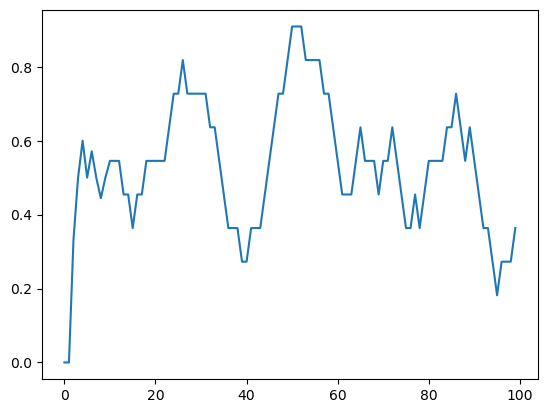

In [ ]:
test_ECM = Priming_ECM(num_actions = 2, action_primes = [0., 1.5])
#Number of steps to run simulation
T = 100
data_log = [None] * T
env = RLGL() #create a default red-light-green-light environment

for t in range(T):
    observation = env.get_observation()
    action = test_ECM.sample(observation)
    reward = env.get_reward(action)
    test_ECM.learn(reward)
    data_log[t] = {"env_state": env.state, "action": action, "reward": reward}
    env.transition(action)

plt.plot(range(T), [np.mean([data_log[step]["reward"] for step in range(i-10,i+1) if step >= 0]) for i in range(T)]) #plot a 10 step moving average of the reward 

## Situated Projective Simulation

### Predictive Bayesian Network

In [ ]:
#| export
import numpy as np

class Bayesian_Network(Abstract_ECM):
    """
    Bayesian Network ECM implementation.
    """

    def __init__(
        self,
        memory: np.ndarray,       # a list of np.arrays,
        transition_matrix: np.ndarray,       # Transition matrix between m-level nodes.
        category_sizes: list,          #number of states per percept category
        m_expectation: np.ndarray = None,  # Optional initial expectation distribution over m-nodes.
        data_record: list = [],       ## a list of variable names to log each time step. Accepts "all"
        record_until: int = -1        ## default of -1 results no data_recording.
    ):
        super().__init__()
        if not sum(category_sizes) == np.shape(memory)[0]:
            raise ValueError("memory must have a number of rows equal to the total number of percept category states")
        self.category_sizes = category_sizes
        self.num_m_nodes = np.shape(memory)[1]              
        self.memory = memory
        if not np.shape(memory)[1] == np.shape(transition_matrix)[1]:
            raise ValueError("memory and Transition must have the same number of columns (m_nodes)")
        if not np.shape(transition_matrix)[0] == np.shape(transition_matrix)[1]:
            raise ValueError("Transition must have the same number of columns and rows (m_nodes)")
        self.transition_matrix = transition_matrix

        # Initialize sensory and m-level excitations as empty arrays
        self.percept = np.empty(len(self.category_sizes))
        self.m_excitation = np.empty(self.num_m_nodes)

        # Set the initial expectation to uniform if none is provided
        if m_expectation is None:
            self.m_expectation = np.full(self.num_m_nodes, fill_value = 1/self.num_m_nodes)
        else:
            self.m_expectation = m_expectation

        # Compute initial sensory expectation as a weighted sum over W_matrix
        self.sensory_expectation = np.dot(self.m_expectation, self.memory.T)

        # Placeholder for current m-node activation vector
        self.m_activation = np.full(self.num_m_nodes, fill_value = 1/self.num_m_nodes)

        self.prepare_data_storage(data_record, record_until)
    
    def prepare_data_storage(self, data_record, record_until):
        #set up data record
        self.data = {"m_expectation": None, 
                     "m_excitation": None, 
                     "m_activation": None,
                     "sensory_expectation": None, 
                     "surprise": None}
        
        self.data_timer = 0
        self.record_until = record_until
        
        if "all" in data_record:
            if len(data_record) > 1:
                print("Warning, data_record contains 'all', additional entries will be ignored")
            data_record = self.data.keys()

        if self.record_until < 0 and len(data_record) > 0:
            print("Warning, 'data_record' indicates data should be recorded but a positive value was not given for 'record_until'. No data will be recorded")

        #add empty data set for each variable in data_log
        for variable in data_record:
            if variable not in self.data.keys():
                print("Warning, " + str(variable) + " in data_record not a valid variable name and will be ignored")
            elif variable in ["m_expectation", "m_excitation", "m_activation"]:
                self.data[variable] = np.full((self.record_until, self.num_m_nodes), fill_value = -1.) #fill value is outside allowable range for variables to indicate unfilled data
            elif variable == "sensory_expectation":
                self.data[variable] = np.full((self.record_until, np.sum(self.category_sizes)), fill_value = -1.) #fill value is outside allowable range for variables to indicate unfilled data
            elif variable == "surprise":
                self.data[variable] = np.full((self.record_until, len(self.category_sizes)), fill_value = -1.) #fill value is outside allowable range for variables to indicate unfilled data
            else:
                print("Warning, unexpected condition in data_record variables")        
    
    def excite_network(
        self,
        percept: np.ndarray  # Binary input vector representing the current percept.
    ):
        """Sets the sensory excitation equal to the percept vector and updates m_excitation accordingly."""
        # Check input shape
        if percept.shape[0] != len(self.category_sizes):
            raise ValueError("Percept vector size does not match the number of perceptual categories.")
        for i in range(len(self.category_sizes)):
            if not percept[i] in range(self.category_sizes[i]):
                raise ValueError("The state of each percept category should be {0,...,N_i - 1}, where N_i is the number of states for that percept category")
                #using 0 for first state helps with indexing memory array
        self.percept = percept

        # compute each m_excitation as the product of each perceptual categories likelihood given that memory,
        active_percept_indices = self.get_active_percept_indices()
        category_likelihoods = self.memory[active_percept_indices,:]
        self.m_excitation = np.prod(category_likelihoods, axis=0) #likelihood of percept given event memory by taking product of values in each column

    def activate(self):
        """Sets m_activation based on m_excitation and m_expectation."""
        # Compute the unnormalized activation (Bayesian inference numerator)
        numerator = self.m_excitation * self.m_expectation

        # Normalize to ensure it sums to one (Bayesian posterior)
        denominator = np.sum(numerator)

        if denominator != 0:
            self.m_activation = numerator / denominator
        else:
            # Avoid division by zero if all values are 0
            print("Warning: Activations sum to 0. This implies the agent believes it can not be in any known state and is likely to cause problems")
            self.m_activation = np.zeros(self.num_m_nodes)

    def set_expectations(self):
        """Set m_expectation and sensory_expectation based on activation and weight matrices."""
        #update m_expectation
        self.predict_state()
        # Update sensory_expectation using a transformed dot product with W_matrix
        self.sensory_expectation = np.dot(self.m_expectation, self.memory.T)

    def predict_state(self):
        row_sums = self.transition_matrix.sum(axis=1, keepdims=True)
        assert(row_sum == 0 or row_sum == 1 for row_sum in row_sums)
        # Update m_expectation using the transition matrix and current activation
        self.m_expectation = np.dot(self.m_activation, self.transition_matrix)

    def get_surprise(self) -> float:
        """Compute the total surprise of the network."""
        # Compute the surprise of each element using the binary cross-entropy formula
        category_expectations = self.sensory_expectation[self.get_active_percept_indices()]
        category_expectations[category_expectations < 0.000001] = 0.000001 #set maximum surprise to avoid log of zero
        surprise_values = -np.log2(category_expectations)

        # Return surprise for each percept category
        return surprise_values

    def get_active_percept_indices(self):
        x = self.percept.astype(int) + (np.cumsum([0] + self.category_sizes[:-1])).astype(int) #add category state to category start index of memory
        return x.tolist()
        
    def sample(self, percept) -> np.ndarray:
        '''given a percept, updates network states and returns a vector of sensory expectations'''
        #record m_expectation
        if self.data_timer < self.record_until and self.data["m_expectation"] is not None:
            self.data["m_expectation"][self.data_timer,:] = self.m_expectation

        #get excitation and record
        self.excite_network(percept)
        if self.data_timer < self.record_until and self.data["m_excitation"] is not None:
            self.data["m_excitation"][self.data_timer,:] = self.m_excitation

        #record surprise
        if self.data_timer < self.record_until and self.data["surprise"] is not None:
            self.data["surprise"][self.data_timer,:] = self.get_surprise()

        #activate and record
        self.activate()
        if self.data_timer < self.record_until and self.data["m_activation"] is not None:
            self.data["m_activation"][self.data_timer,:] = self.m_activation

        #predict
        self.set_expectations()

        #Advance timer for data logging
        self.data_timer += 1
                                           
        return self.sensory_expectation

#### Example

In this example, we set up an environment that alternates between flipping a pair of biased coins and a pair of fair coins. The Bayesian Network's memory gives it the probabilities of the coin flips in each state, and the Transition Array gives it the alternating state sequence pattern. The network does not know which state the system starts in, however. By recording and plotting the predictions the Bayesian Network, we can see how accumulating sensory evidence over times allows the Bayesian Network to establish which state the system is in and make accurate state-based predictions about the next flips.

In [ ]:
#Set up Paramters 
T = 100
probabilities = np.array([[0.7,0.5],
                         [0.3,0.5],
                         [0.4,0.5],
                         [0.6,0.5]])
category_sizes = [2,2]
transition_matrix = np.array(([0,1],[1,0])) #state transition probabilities

#Create variable for storing prediction data and initialize bayesian network instance
predictions = np.zeros((np.shape(probabilities)[0],T)) #time steps by number of perceptual categories
test_bayesian_net = Bayesian_Network(memory = probabilities, transition_matrix = transition_matrix, category_sizes = category_sizes)

heads_probs_biased = probabilities[[0,2],0]
heads_probs_fair = probabilities[[0,2],1]
for t in range(T):
    if t % 2 == 0: #biased state first
        percept = np.random.binomial(n = 1, p = heads_probs_biased)
    else:          #fair state second
        percept = np.random.binomial(n = 1, p = heads_probs_fair) 

    predictions[:,t] = test_bayesian_net.sample(percept)

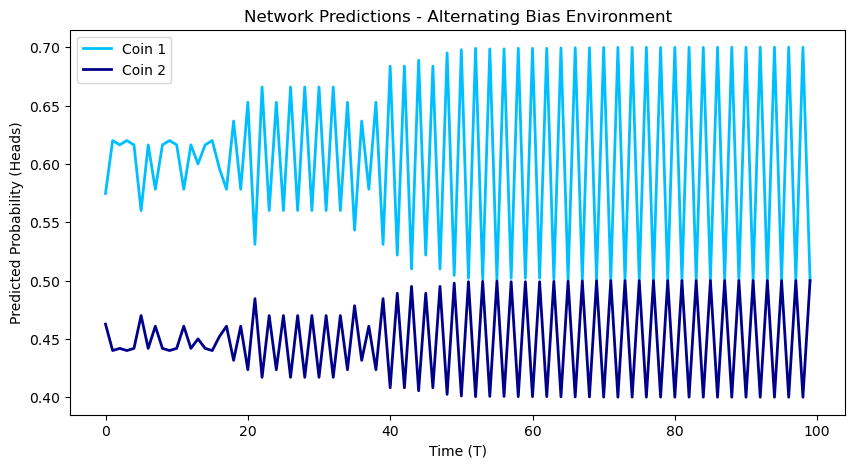

In [ ]:
"""
Plot the predicted probabilities over time
"""
plt.figure(figsize=(10, 5))
plt.plot(range(T), [predictions[0,i] for i in range(T)], label='Coin 1', linewidth=2, color='deepskyblue') #plot expected probabilitiy of coin 1 heads
plt.plot(range(T), [predictions[2,i] for i in range(T)], label='Coin 2', linewidth=2, color='darkblue') #plot expected probabilitiy of coin 2 heads

plt.xlabel("Time (T)")
plt.ylabel("Predicted Probability (Heads)")
plt.title("Network Predictions - Alternating Bias Environment")
plt.legend(loc = 2)
plt.show()

### Bayesian Memory Network

In [ ]:
#|export

from projective_simulation.methods.transforms import _logistic, _exponentiated_shift
import numpy as np

class Bayesian_Memory(Bayesian_Network):
    """
    Bayesian_Memory is a memory-augmented extension of the Bayesian_Network.
    It supports dynamic modification of internal weights to encode temporal traces.
    """
    def __init__(
        self,
        category_sizes: list,                    # Number of sensory input elements.
        num_m_nodes: int,                        # Number of memory nodes.
        memory: np.ndarray = None,               # Optional sensory-to-memory weight matrix.
        m_expectation: np.ndarray = None,        # Optional 1d array of prior expectations on memories
        transition_matrix: np.ndarray = None,     # Optional memory transition matrix.
        timer: int = 0,                          # Starting memory time index.
        data_record: list = [],                      # a list of variable names to log each time step. Accepts "all"
        record_until: int = -1                    # number of steps to prepare for data logging, negative values result in no data recording
    ):
        # Default to informationless percept element probabilities if none provided
        if memory is None:
            uniform_probabilities = np.concatenate([np.full(category_size, fill_value = 1/category_size) for category_size in category_sizes])
            memory = uniform_probabilities[:, np.newaxis] * np.ones(num_m_nodes, dtype=uniform_probabilities.dtype) #set each memory node (columns) to uniform probabilities

        # Default to uniform transitions if none provided
        if transition_matrix is None:
            transition_matrix = np.zeros((num_m_nodes, num_m_nodes))
            
        super().__init__(memory = memory, 
                         transition_matrix = transition_matrix, 
                         category_sizes = category_sizes, 
                         m_expectation = m_expectation, 
                         data_record = data_record,
                         record_until = record_until
                        )
        
        self.timer = timer
        if m_expectation is None:
            #overwrite default from super() so that expectation is set on enencoded trace that precedes the one given by initial timer value
            self.m_expectation = np.zeros(self.num_m_nodes)
            self.m_expectation[timer-1] = 1
        
        self.enforce_structure()        

    def enforce_structure(self):
        """
        runs checks to ensure that all variables in the Bayesian_Memory are properly defined
        """
        
        #enforce probability distribution in each percept category of encoded memories and predictions
        category_start_index = 0
        for i in range(len(self.category_sizes)):
            category_sums_memory = np.sum(self.memory[range(category_start_index, category_start_index + self.category_sizes[i]),:], axis = 0)
            if not np.all(np.abs(category_sums_memory - 1) < 1e-9): #allows for floating-point precision
                raise ValueError("""Each memory trace must encode a probability distribution over each category. 
                When the Memory Network's internal timer was set to """ + str(self.timer) + """
                at least one column in 'memory' did not contain values that sum to 1 for category """ + str(i))

            category_sum_prediction = np.sum(self.sensory_expectation[range(category_start_index, category_start_index + self.category_sizes[i])])
            if not np.abs(category_sum_prediction - 1) < 1e-9:
                raise ValueError("""Expecations for each percept category must be a probability distribution. 
                When the Memory Network's internal timer was set to """ + str(self.timer) + """
                sensory_expectation did not sum to 1 for category """ + str(i))
                                                                      
            category_start_index += self.category_sizes[i]

        #enforce probability structure in activation, expectation, and excitation
        if not np.abs(np.sum(self.m_activation) - 1) < 1e-9:
            raise ValueError("""memory trace activation must be a probability distiribution.
            When the Memory Network's internal timer was set to """ + str(self.timer) + """
            m_activation did not sum to 1""")

        if not np.abs(np.sum(self.m_expectation) -1 ) < 1e-9:
            raise ValueError("""memory trace expectation must be a probability distiribution.
            When the Memory Network's internal timer was set to """ + str(self.timer) + """
            m_expectation did not sum to 1""")

        if not np.all(self.m_excitation >= 0) and not np.all(self.m_excitation <= 1):
            raise ValueError("""memory trace excitation must be a probability.
            When the Memory Network's internal timer was set to """ + str(self.timer) + """
            at least one value of m_excitation was not between 0 and 1""")

        if self.record_until is not None:
            if self.record_until >= 0 and self.data_timer == self.record_until + 1:
                print("Warning, memory process has exceded steps pre-allocated for data-recording. Further variable states will not be stored")
        
    def sample(self, percept):
        #record m_expectation and sensory expectation
        if self.data_timer < self.record_until and self.data["m_expectation"] is not None:
            self.data["m_expectation"][self.data_timer,:] = self.m_expectation

        if self.data_timer < self.record_until and self.data["sensory_expectation"] is not None:
            self.data["sensory_expectation"][self.data_timer,:] = self.sensory_expectation

        #get excitation and record
        self.excite_network(percept)
        if self.data_timer < self.record_until and self.data["m_excitation"] is not None:
            self.data["m_excitation"][self.data_timer,:] = self.m_excitation

        #record surprise
        if self.data_timer < self.record_until and self.data["surprise"] is not None:
            self.data["surprise"][self.data_timer,:] = self.get_surprise()

        #activate and record
        self.activate()
        if self.data_timer < self.record_until and self.data["m_activation"] is not None:
            self.data["m_activation"][self.data_timer,:] = self.m_activation

        #encode memory
        self.encode_memory()

        #predict
        self.set_expectations()

        # Advance Memory network's internal timer
        self.timer = (self.timer + 1) % self.num_m_nodes

        #Advance timer for data logging
        self.data_timer += 1
        
        self.enforce_structure()
        return self.sensory_expectation
        
    def encode_memory(self):
        """
        Modify W_matrix and C_matrix to encode the current percept into memory.
        This sets the current memory trace's excitation weights and transition weights.
        """
        # Encode current sensory excitation into memory
        
        categorical_encoding = np.zeros(np.shape(self.memory)[0]) #initialize with 0s
        categorical_encoding[self.get_active_percept_indices()] = 1 #set active percept states to 1
        self.memory[:, self.timer] = categorical_encoding

        # Set transition from previous trace to current trace

        self.transition_matrix[self.timer - 1, self.timer] = 1

    def excite_network(
        self,
        percept: np.ndarray  # each element gives the state of a perceptual category
    ):
        """
        Similar to function of same name for Bayesian_Network, exponentiated shift is applied to sensory evidence weights.
        This adds uncertainty as a function of the sensory evidence prior
        """
        #enforce percept structure
        if percept.shape[0] != len(self.category_sizes):
            raise ValueError("Percept vector size does not match the number of perceptual categories.")
        for i in range(len(self.category_sizes)):
            if not percept[i] in range(self.category_sizes[i]):
                raise ValueError("The state of each percept category should be in {0,...,N_i - 1}, where N_i is the number of states for that percept category")
                #using 0 for first state helps with indexing memory array
        
        self.percept = percept

        # compute each m_excitation as the product of each perceptual category's likelihood given that memory,
        active_percept_indices = self.get_active_percept_indices()
        category_likelihoods = self.memory[active_percept_indices,:]
        self.m_excitation = np.prod(category_likelihoods, axis=0) #likelihood of percept given event memory by taking product of values in each column

    
    def activate(self):
        """Sets m_activation based on m_excitation and m_expectation. Differs from Bayesian_Network only in how edge case of 0 activation is handled"""
        # Compute the unnormalized activation (Bayesian inference numerator)
        numerator = self.m_excitation * self.m_expectation

        # Normalize to ensure it sums to one (Bayesian posterior)
        denominator = np.sum(numerator)

        if denominator != 0:
            self.m_activation = numerator / denominator
        else:
            # if all values are 0, evenly divide activation across all encoded traces
            encoded_traces_bool = self.transition_matrix.sum(axis=0) > 0 #true if there is a transition leading to trace (meaning it has been encoded)
            num_encoded_traces = np.sum(encoded_traces_bool)
            self.m_activation = np.where(encoded_traces_bool, 1/num_encoded_traces, 0) #inputs: condition, value if true, value if false
        
    

### Example

In this example, set up a cyclical Hidden Markov Process in which a light turns green, turns off, turns blue, turns off, then turns green again and restarts. We show how to pass the percepts from this environment to the Memory Network, record the network's internal states over time, and visualize these states after simuluation.

In [ ]:
from projective_simulation.environments import Cyclic_Env
from projective_simulation.methods.visualization import plot_heatmap

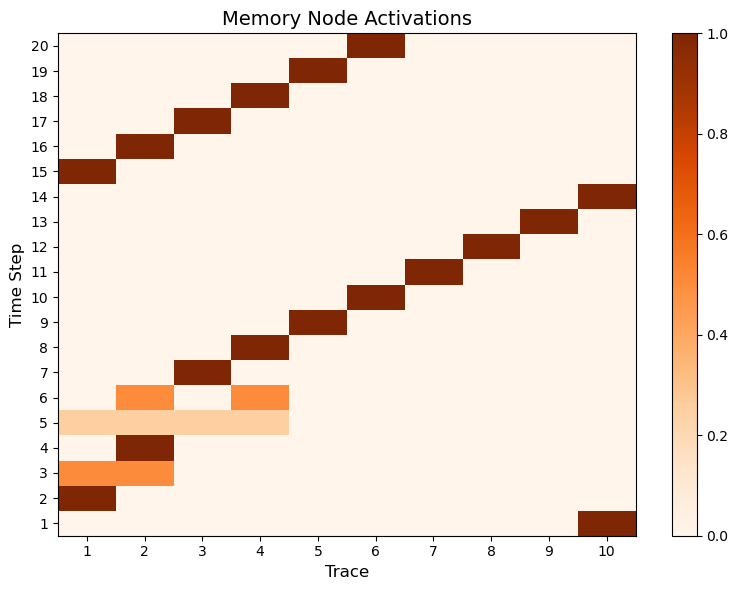

In [ ]:
#define percepts
off = 0
green = 1
blue = 2
colormap = np.array(['lightgrey', 'green', 'blue']) #for plotting

#define environment
percept_cycle = np.array([green,off,blue,off]) #light off, light green, light off, light blue
simple_light_cycle = Cyclic_Env(percept_cycle)


#define agent
num_m_nodes = 10
category_sizes = [3]
test_bayesian_memory = Bayesian_Memory(category_sizes = category_sizes, 
                                       num_m_nodes = num_m_nodes
                                      )

#prepare simulation
T = 20 #total time to run simulation
test_bayesian_memory.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = simple_light_cycle.get_observation()
    test_bayesian_memory.sample(percept)
    simple_light_cycle.transition()

#plot memory trace activations over time
plot_heatmap(test_bayesian_memory.data["m_activation"], title = "Memory Node Activations", color = "Oranges")

## Forgetful Memory Network

In [ ]:
#| export
from projective_simulation.methods.transforms import _decay_toward_uniform, _logit_bias

class Forgetful_Memory(Bayesian_Memory):
    def __init__(self,
                 category_sizes: list,                    # Number of sensory input elements.
                 num_m_nodes: int,                        # Number of memory nodes.
                 forgetting_rate: float,                  # rate parameter on the exponential decay toward uniform for values in each percept category of memory traces
                 belief_uncertainty: float,                      # constant to add to m_expectation before renormalization
                 memory: np.ndarray = None,               # Optional sensory-to-memory weight matrix.
                 m_expectation: np.ndarray = None,        # Optional 1d array of prior expectations on memories
                 transition_matrix: np.ndarray = None,     # Optional memory transition matrix.
                 timer: int = 0,                          # Starting memory time index.
                 data_record: list = [],                      # a list of variable names to record each time step. Accepts "all"
                 record_until: int = -1                    # number of steps to prepare for data recording, negative values result in no data recording
                ):
        super().__init__(category_sizes, num_m_nodes, memory, m_expectation, transition_matrix, timer, data_record, record_until)
        self.forgetting_rate = forgetting_rate
        self.belief_uncertainty = belief_uncertainty

    def sample(self, percept):
        self.forget()
        return super().sample(percept)

    def predict_state(self):
        """Set m_expectation and sensory_expectation based on activation and weight matrices."""
        super().predict_state()
        encoded_traces_bool = np.sum(self.transition_matrix, axis = 0) != 0.
        self.m_expectation[encoded_traces_bool] = self.m_expectation[encoded_traces_bool] + self.belief_uncertainty #add uncertainty
        self.m_expectation = self.m_expectation/np.sum(self.m_expectation) #renormalize

    def forget(self):
        category_start_index = 0
        for i in range(len(self.category_sizes)):
            category_memories = self.memory[category_start_index:category_start_index + self.category_sizes[i], :]
            category_memories = _decay_toward_uniform(category_memories, self.forgetting_rate)
            self.memory[category_start_index:category_start_index + self.category_sizes[i], :] = category_memories


            

### Example

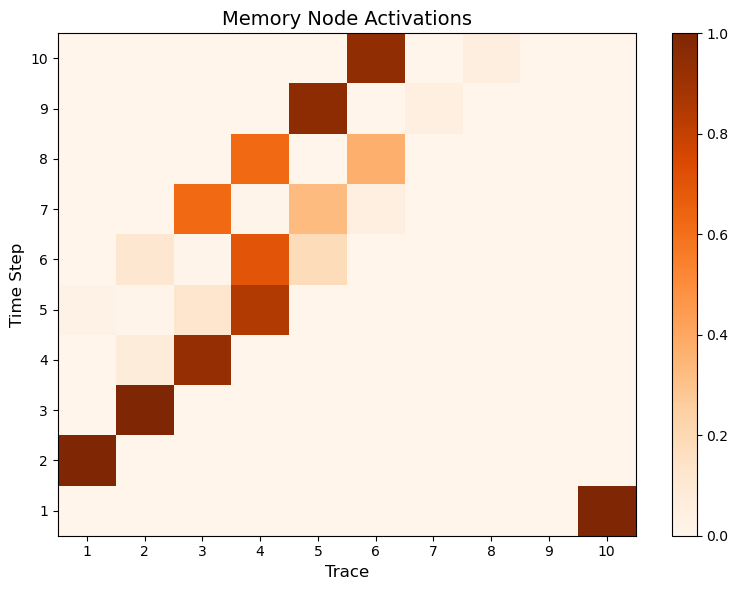

In [ ]:
#define percepts
off = 0
green = 1
blue = 2
colormap = np.array(['lightgrey', 'green', 'blue']) #for plotting

#define environment
percept_cycle = np.array([green,off,blue,off]) #light off, light green, light off, light blue
simple_light_cycle = Cyclic_Env(percept_cycle)


#define agent
num_m_nodes = 10
category_sizes = [3]
test_forgetful_memory = Forgetful_Memory(category_sizes = category_sizes, 
                                         num_m_nodes = num_m_nodes,
                                         forgetting_rate = 0.1,
                                         belief_uncertainty = 0.001
                                      )

#prepare simulation
T = 10 #total time to run simulation
test_forgetful_memory.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = simple_light_cycle.get_observation()
    test_forgetful_memory.sample(percept)
    simple_light_cycle.transition()

#plot memory trace activations over time
plot_heatmap(test_forgetful_memory.data["m_activation"], title = "Memory Node Activations", color = "Oranges")

In [ ]:
test_forgetful_memory.memory

## Selective Forgetting

In [ ]:
#| export
from projective_simulation.methods.transforms import _decay_toward_uniform, _logit_bias

class Selectively_Forgetful_Memory(Bayesian_Memory):
    def __init__(self,
                 category_sizes: list,                    # Number of sensory input elements.
                 num_m_nodes: int,                        # Number of memory nodes.
                 forgetting_rate: float,                  # rate parameter on the exponential decay toward uniform for values in each percept category of memory traces
                 belief_uncertainty: float,                      # constant to add to m_expectation before renormalization
                 memory: np.ndarray = None,               # Optional sensory-to-memory weight matrix.
                 m_expectation: np.ndarray = None,        # Optional 1d array of prior expectations on memories
                 transition_matrix: np.ndarray = None,     # Optional memory transition matrix.
                 timer: int = 0,                          # Starting memory time index.
                 data_record: list = [],                      # a list of variable names to record each time step. Accepts "all"
                 record_until: int = -1                    # number of steps to prepare for data recording, negative values result in no data recording
                ):
        super().__init__(category_sizes, num_m_nodes, forgetting_rate, belief_uncertainty, memory, m_expectation, transition_matrix, timer, data_record, record_until)
        self.surprise_advantage_encodings = np.zeros((len(self.category_sizes), self.num_m_nodes))

    def predict_state(self):
        """Set m_expectation and sensory_expectation based on activation and weight matrices."""
        super().predict_state()
        encoded_traces_bool = np.sum(self.transition_matrix, axis = 0) != 0.
        self.m_expectation[encoded_traces_bool] = self.m_expectation[encoded_traces_bool] + self.belief_uncertainty #add uncertainty
        self.m_expectation = self.m_expectation/np.sum(self.m_expectation) #renormalize

    def get_expected_surprise(self):
        category_start_index = 0 #will iterate over category sizes, adding to this variable as we go
        expected_surprises = np.zeros(len(self.category_sizes))
        for i in range(len(self.category_sizes)):
            category_expectations = self.sensory_expectation[category_start_index:category_start_index + self.category_sizes[i]]
            entropy_contributions = np.zeros_like(category_expectations) #default value for category states with 0 expectations
            unmask = category_expectations != 0
            entropy_contributions[unmask] = -category_expectations[unmask] * np.log2(category_expectations[unmask])
            expected_surprises[i] = np.sum(entropy_contributions) #entropy of category given predicted probabilities
            category_start_index += self.category_sizes[i]
        return expected_surprises

    def forget(self):
        category_start_index = 0
        for i in range(len(self.category_sizes)):
            category_memories = self.memory[category_start_index:category_start_index + self.category_sizes[i], :]
            alphas = _logit_bias(self.forgetting_rate, self.surprise_advantage_encodings[i,:]) #forgetting rate biased by surprise advantage for given category in each memory
            category_memories = _decay_toward_uniform(category_memories, alphas)
            self.memory[category_start_index:category_start_index + self.category_sizes[i], :] = category_memories

#| hide
# nbdev export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()